In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm



In [ ]:
#client 
import numpy as np

class client(object):
    def __init__(self,
                 index,
                 thorizon,
                 narms,
                 nclients,
                 palpha,
                 fp):
        self.T = thorizon
        self.id = index
        self.K = narms
        self.M = nclients
        self.alpha = palpha
        self.fp = fp
        
        self.p = 1
        self.local_set = set(np.arange(self.K))
        self.global_set = set(np.arange(self.K))
        self.local_mean = np.zeros(self.K)
        self.global_mean = np.zeros(self.K)
        self.mixed_mean = np.zeros(self.K)
        self.reward = np.zeros(self.K)
        
        self.pull = np.zeros(self.K)
        self.p_length = self.fp(self.p)
        self.Fp = 0
        
        self.fphase = 0
        self.gphase = 0
        
        self.F = -1
        self.l_exploration = False
        self.g_exploration = False
    
    def play(self):
        if self.fphase < np.ceil((1-self.alpha)*self.p_length)*len(self.global_set): #global exploration
#            print("loc", self.p)
            #play = list(self.global_set)[self.fphase%len(self.global_set)]
            play = list(self.global_set)[int(self.fphase//(np.ceil((1-self.alpha)*self.p_length)))]
            self.fphase += 1
            
        elif self.gphase < np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set): #local exploration
#            print("glob", self.p)
            #play = list(self.local_set)[self.gphase%len(self.local_set)]
            play = list(self.local_set)[int(self.gphase//(np.ceil(self.M*self.alpha*self.p_length)))]
            self.gphase += 1
            
        else: #exploitation phase
            if self.l_exploration is True:
                play = self.F
            else:
                play = np.argmax(self.alpha*self.local_mean+(1-self.alpha)*self.global_mean)
            
        return play
    
    def reward_update(self,play,obs):
        self.reward[play] += obs
        self.pull[play] += 1
        
    def local_mean_update(self):
        #print('global',self.fphase,np.ceil((1-self.alpha)*self.p_length)*len(self.global_set))
        #print('local',self.gphase,np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set))
        if self.g_exploration is False and self.fphase >= np.ceil((1-self.alpha)*self.p_length)*len(self.global_set) and self.gphase >= np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set):
            self.local_mean = self.reward/self.pull
            #print("local_mean",self.local_mean, "phase", self.p)
            return True, self.local_mean
        else:
            return False, 0
        
    def global_mean_update(self,global_stat):
        self.global_mean = global_stat
        self.mixed_mean = self.alpha*self.local_mean+(1-self.alpha)*self.global_mean
        
    def local_set_update(self):
        Ep = set()
        self.Fp += self.p_length
        conf_bound = np.sqrt(np.log(self.T)/(self.M*self.Fp))
        for i in list(self.local_set):
            if self.mixed_mean[i]+conf_bound < max(self.mixed_mean-conf_bound):
                Ep.add(i)
        self.local_set = self.local_set-Ep
        
        if len(self.local_set) == 1 and self.l_exploration is False:
            self.l_exploration = True
            self.F = list(self.local_set)[0]
            #print("player", self.id,  " fixate",self.F)
            self.local_set = set()
        #print("player", self.id, " local-set:",self.local_set)    
        return self.local_set
        
        
    def global_set_update(self,global_set):
        self.global_set = global_set
        self.p +=1
        self.p_length = self.fp(self.p)
        #print("p-length",self.p_length)
        self.fphase = 0
        self.gphase = 0
        self.g_exploration = (len(self.global_set)==0)
        
            
            
    
            

In [ ]:
#server

import numpy as np

class server(object):
    def __init__(self,
                 narms,
                 nclients):
        self.M = nclients
        self.K = narms
        
        self.local_means = np.zeros([self.M,self.K])
        self.global_means = np.zeros(self.K)
        self.global_set = set()
        self.p = 1
        self.c_local_stat = np.zeros(self.M)
        
    def local_mean_update(self,i,local_stat):
        self.local_means[i] = local_stat
        self.c_local_stat[i] = 1
        
    def global_mean_update(self):
        self.global_set = set()
        if sum(self.c_local_stat) >= self.M:
            self.global_means = np.sum(self.local_means, axis=0)/self.M
            self.c_local_stat = np.zeros(self.M)
            return True, self.global_means
        else:
            return False, 0
        
    def local_set_update(self,i,local_set):
        self.global_set = self.global_set|local_set
    
    def global_set_update(self):
        return self.global_set

In [ ]:
#bandits
class PFEDUCB(object):
    def __init__(self,
                 fun_fp,
                 T,
                 means, # M*K
                 alpha,
                 reward='Gaussian'):
        self.M = means.shape[0]
        self.K = means.shape[1]
        self.local_means = means
        self.reward_type = reward
        self.alpha = alpha
        self.T = T
        self.C = 1
        self.comm = 0
        
        self.global_means = np.sum(self.local_means, axis=0)/self.M
        self.clients = [
            client(index = i, thorizon = self.T, narms=self.K, nclients = self.M, palpha = self.alpha, fp=fun_fp) for i in range(self.M)
        ]
        self.server = server(narms=self.K, nclients = self.M)


    def simulate_single_step_rewards(self):
        if self.reward_type == 'Bernoulli':
            return np.random.binomial(1, self.local_means)
        return np.random.normal(self.local_means, 1)

    def simulate_single_step(self, plays):

        local_rews = self.simulate_single_step_rewards()
        global_rews = np.mean(local_rews,axis=0)
        
        local_rewards = np.array([local_rews[i,plays[i]] for i in range(self.M)])
        global_rewards = np.array([global_rews[plays[i]] for i in range(self.M)])
        mixed_rewards = self.alpha*local_rewards+(1-self.alpha)*global_rewards
        #rewards = np.array([self.alpha*local_rews[i,plays[i]]+(1-self.alpha)*global_rews[plays[i]] for i in range(self.M)])

        return local_rewards, global_rewards, mixed_rewards

    def simulate(self):
        """
        Return the vector of regret for each time step until horizon
        """

        local_rewards = []
        global_rewards = []
        mixed_rewards = []
        
        play_history = []
           

        for t in range(self.T):
            plays = np.zeros(self.M)
            
            plays = [(int)(client.play()) for client in self.clients]
            local_rews, global_rews, mixed_rews = self.simulate_single_step(plays)
            #obs, rews = self.simulate_single_step(plays)  # observations of all players
            
            local_rewards.append(np.sum(local_rews))
            global_rewards.append(np.sum(global_rews))
            mixed_rewards.append(np.sum(mixed_rews))
            play_history.append(plays)
            
            #print(plays)
            
            for i in range(self.M):
                self.clients[i].reward_update(plays[i], local_rews[i])  # update strategies of all player

            for i in range(self.M):
                f_local_stat, local_stat = self.clients[i].local_mean_update()
                if f_local_stat is True:
                    self.server.local_mean_update(i,local_stat)
                f_local_stat = False
                    
            f_global_stat, global_stat = self.server.global_mean_update()
            
            if f_global_stat is True:
                for i in range(self.M):
                    self.clients[i].global_mean_update(global_stat)
                    local_set = self.clients[i].local_set_update()
                    self.server.local_set_update(i,local_set)
                
                global_set = self.server.global_set_update()
                #print(t," global-set:",global_set)
                for i in range(self.M):
                    self.clients[i].global_set_update(global_set)
                    local_rewards[-1] -= 2*self.C
                    global_rewards[-1] -= 2*self.C
                    mixed_rewards[-1] -= 2*self.C
                    self.comm += 2*self.C
                    #print(t,"comm")
                f_global_stat = False
            
        top_mixed_means = np.zeros(self.M)
        
        top_arms = np.zeros(self.M, dtype=int)
        sub_gap = np.zeros(self.M)
        for i in range(self.M):
            top_arms[i] = np.argmax(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)
            top_mixed_means[i] = self.alpha*self.local_means[i][top_arms[i]]+(1-self.alpha)*self.global_means[top_arms[i]]
            sub_gap[i] = np.sort(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)[-2]-top_mixed_means[i]
            #print("player", i, " top_arm:",top_arms[i], " top_mean:", top_mixed_means[i], " gap:", sub_gap[i])
        
        best_case_reward = np.sum(top_mixed_means) * np.arange(1, self.T + 1)
        
        cumulated_local_reward = np.cumsum(local_rewards)
        cumulated_global_reward = np.cumsum(global_rewards)
        cumulated_mixed_reward = np.cumsum(mixed_rewards)

        regret = best_case_reward - cumulated_mixed_reward
#        print(cumulated_mixed_reward)
#        print(best_case_reward)
#        print('regret:',regret[-1], "comm: ", self.comm)
        self.regret = (regret, best_case_reward, cumulated_mixed_reward)
        self.top_mixed_means = top_mixed_means
        return regret, cumulated_local_reward, cumulated_global_reward, cumulated_mixed_reward

    def get_clients(self):
        return self.clients

In [ ]:
import numpy as np

class imp_client(object):
    def __init__(self,
                 index,
                 thorizon,
                 narms,
                 nclients,
                 palpha,
                 fp):
        self.T = thorizon
        self.id = index
        self.K = narms
        self.M = nclients
        self.alpha = palpha
        self.fp = fp
        
        self.p = 1
        self.local_set = set(np.arange(self.K))
        self.global_set = set(np.arange(self.K))
        self.local_mean = np.zeros(self.K)
        self.global_mean = np.zeros(self.K)
        self.mixed_mean = np.zeros(self.K)
        
        self.local_delta = np.ones(self.K)
        self.global_delta = np.ones([self.M,self.K])
        
        self.reward = np.zeros(self.K)
        self.pull = np.zeros(self.K)
        self.p_length = self.fp(self.p)
        self.Fp = 0
        
        self.farm = 0
        self.farm_pull = np.zeros(self.K)
        self.garm = 0
        self.garm_pull = np.zeros(self.K)
        self.imp_factor = (self.alpha*np.sqrt(self.local_delta)+(1-self.alpha)/self.M*np.sum(np.sqrt(self.global_delta),axis=0))/np.sqrt(self.local_delta)
        self.farm_pull_bound = np.ceil((1-self.alpha)*self.p_length*self.imp_factor)
        self.garm_pull_bound = np.ceil(self.alpha*self.M*self.p_length*self.imp_factor)
        
        self.F = -1
        self.l_exploration = False
        self.g_exploration = False
    
    def play(self):
        if self.farm < len(self.global_set):
            play = list(self.global_set)[int(self.farm)]
            self.farm_pull[play] += 1
            if self.farm_pull[play] >= self.farm_pull_bound[play]:
                self.farm += 1
                
        elif self.garm < len(self.local_set):
            play = list(self.local_set)[int(self.garm)]
            self.garm_pull[play] += 1
            if self.garm_pull[play] >= self.garm_pull_bound[play]:
                self.garm += 1
            
        else: #exploitation phase
            if self.l_exploration is True:
                play = self.F
            else:
                play = np.argmax(self.alpha*self.local_mean+(1-self.alpha)*self.global_mean)
            
        return play
    
    def reward_update(self,play,obs):
        self.reward[play] += obs
        self.pull[play] += 1
        
    def local_mean_update(self):
        #print('global',self.fphase,np.ceil((1-self.alpha)*self.p_length)*len(self.global_set))
        #print('local',self.gphase,np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set))
        if self.g_exploration is False and self.farm>= len(self.global_set) and self.garm>= len(self.local_set):
            self.local_mean = self.reward/self.pull
            #print("local_mean",self.local_mean, "phase", self.p)
            return True, self.local_mean
        else:
            return False, 0
        
    def global_mean_update(self,global_stat):
        self.global_mean = global_stat
        self.mixed_mean = self.alpha*self.local_mean+(1-self.alpha)*self.global_mean
        
    def local_set_update(self):
        Ep = set()
        self.Fp += self.p_length
        conf_bound = np.sqrt(np.log(self.T)/(self.M*self.Fp))
        for i in list(self.local_set):
            if self.mixed_mean[i]+conf_bound < max(self.mixed_mean-conf_bound):
                Ep.add(i)
        self.local_set = self.local_set-Ep
        
        if len(self.local_set) == 1 and self.l_exploration is False:
            self.l_exploration = True
            self.F = list(self.local_set)[0]
            #print("player", self.id,  " fixate",self.F)
            self.local_set = set()
        #print("player", self.id, " local-set:",self.local_set)    
        return self.local_set
        
    def local_delta_update(self):
        self.local_delta = np.minimum(np.ones(self.K)*np.max(self.mixed_mean)-self.mixed_mean+2*np.sqrt(np.log(self.T)/(self.M*self.Fp)),np.ones(self.K))
        #self.local_delta = np.minimum(np.ones(self.K)*np.max(self.mixed_mean)-self.mixed_mean+2*np.sqrt(np.log(self.T)/(self.M*self.Fp)),np.ones(self.K))
        #self.local_delta = np.ones(self.K)
        return self.local_delta
        
    def global_set_update(self,global_set):
        self.global_set = global_set
        
    def global_delta_update(self,global_delta):
        self.global_delta = global_delta
        self.p +=1
        self.p_length = self.fp(self.p)
        #print("p-length",self.p_length)
        self.farm = 0
        self.farm_pull = np.zeros(self.K)
        self.garm = 0
        self.garm_pull = np.zeros(self.K)
        self.imp_factor = (self.alpha*np.sqrt(self.local_delta)+(1-self.alpha)/self.M*np.sum(np.sqrt(self.global_delta),axis=0))/np.sqrt(self.local_delta)
        #print("imp factor:", self.imp_factor)
        self.farm_pull_bound = np.ceil((1-self.alpha)*self.p_length*self.imp_factor)
        self.garm_pull_bound = np.ceil(self.alpha*self.M*self.p_length*self.imp_factor)
        
        self.g_exploration = (len(self.global_set)==0)
        
            
            
    

In [ ]:
import numpy as np

class imp_server(object):
    def __init__(self,
                 narms,
                 nclients):
        self.M = nclients
        self.K = narms
        
        self.local_means = np.zeros([self.M,self.K])
        self.global_means = np.zeros(self.K)
        self.global_set = set()
        self.global_delta = np.ones([self.M, self.K])
        
        self.p = 1
        self.c_local_stat = np.zeros(self.M)
        
    def local_mean_update(self,i,local_stat):
        self.local_means[i] = local_stat
        self.c_local_stat[i] = 1
        
    def global_mean_update(self):
        self.global_set = set()
        if sum(self.c_local_stat) >= self.M:
            self.global_means = np.sum(self.local_means, axis=0)/self.M
            self.c_local_stat = np.zeros(self.M)
            return True, self.global_means
        else:
            return False, 0
       
    def local_set_update(self,i,local_set):
        self.global_set = self.global_set|local_set
    
    def local_delta_update(self,i,local_delta):
        self.global_delta[i] = local_delta
    
    def global_set_update(self):
        return self.global_set
    
    def global_delta_update(self):
        #print("global delta:", self.global_delta)
        return self.global_delta

In [ ]:
import numpy as np
#from client_improved import imp_client
#from server_improved import imp_server

class IMP_PFEDUCB(object):
    def __init__(self,
                 fun_fp,
                 T,
                 means, # M*K
                 alpha,
                 reward='Gaussian'):
        self.M = means.shape[0]
        self.K = means.shape[1]
        self.local_means = means
        self.reward_type = reward
        self.alpha = alpha
        self.T = T
        self.C = 1
        self.comm = 0
        
        self.global_means = np.sum(self.local_means, axis=0)/self.M
        self.clients = [
            imp_client(index = i, thorizon = self.T, narms=self.K, nclients = self.M, palpha = self.alpha, fp=fun_fp) for i in range(self.M)
        ]
        self.server = imp_server(narms=self.K, nclients = self.M)


    def simulate_single_step_rewards(self):
        if self.reward_type == 'Bernoulli':
            return np.random.binomial(1, self.local_means)
        return np.random.normal(self.local_means, 1)

    def simulate_single_step(self, plays):

        local_rews = self.simulate_single_step_rewards()
        global_rews = np.mean(local_rews,axis=0)
        
        local_rewards = np.array([local_rews[i,plays[i]] for i in range(self.M)])
        global_rewards = np.array([global_rews[plays[i]] for i in range(self.M)])
        mixed_rewards = self.alpha*local_rewards+(1-self.alpha)*global_rewards
        #rewards = np.array([self.alpha*local_rews[i,plays[i]]+(1-self.alpha)*global_rews[plays[i]] for i in range(self.M)])

        return local_rewards, global_rewards, mixed_rewards

    def simulate(self):
        """
        Return the vector of regret for each time step until horizon
        """

        local_rewards = []
        global_rewards = []
        mixed_rewards = []
        
        play_history = []
           

        for t in range(self.T):
            plays = np.zeros(self.M)
            
            plays = [(int)(client.play()) for client in self.clients]
            local_rews, global_rews, mixed_rews = self.simulate_single_step(plays)
            #obs, rews = self.simulate_single_step(plays)  # observations of all players
            
            local_rewards.append(np.sum(local_rews))
            global_rewards.append(np.sum(global_rews))
            mixed_rewards.append(np.sum(mixed_rews))
            play_history.append(plays)
            
            #print(plays)
            
            for i in range(self.M):
                self.clients[i].reward_update(plays[i], local_rews[i])  # update strategies of all player

            for i in range(self.M):
                f_local_stat, local_stat = self.clients[i].local_mean_update()
                if f_local_stat is True:
                    self.server.local_mean_update(i,local_stat)
                f_local_stat = False
                    
            f_global_stat, global_stat = self.server.global_mean_update()
            
            if f_global_stat is True:
                for i in range(self.M):
                    self.clients[i].global_mean_update(global_stat)
                    local_set = self.clients[i].local_set_update()
                    local_delta = self.clients[i].local_delta_update()
                    self.server.local_set_update(i,local_set)
                    self.server.local_delta_update(i,local_delta)
                
                global_set = self.server.global_set_update()
                global_delta = self.server.global_delta_update()
                #print(t," global-set:",global_set)
                for i in range(self.M):
                    self.clients[i].global_set_update(global_set)
                    self.clients[i].global_delta_update(global_delta)
                    local_rewards[-1] -= 2*self.C
                    global_rewards[-1] -= 2*self.C
                    mixed_rewards[-1] -= 2*self.C
                    self.comm += 2*self.C
                    #print(t,"comm")
                f_global_stat = False
            
        top_mixed_means = np.zeros(self.M)
        
        top_arms = np.zeros(self.M, dtype=int)
        sub_gap = np.zeros(self.M)
        for i in range(self.M):
            top_arms[i] = np.argmax(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)
            top_mixed_means[i] = self.alpha*self.local_means[i][top_arms[i]]+(1-self.alpha)*self.global_means[top_arms[i]]
            sub_gap[i] = np.sort(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)[-2]-top_mixed_means[i]
            #print("player", i, " top_arm:",top_arms[i], " top_mean:", top_mixed_means[i], " gap:", sub_gap[i])
        
        best_case_reward = np.sum(top_mixed_means) * np.arange(1, self.T + 1)
        
        cumulated_local_reward = np.cumsum(local_rewards)
        cumulated_global_reward = np.cumsum(global_rewards)
        cumulated_mixed_reward = np.cumsum(mixed_rewards)

        regret = best_case_reward - cumulated_mixed_reward
#        print(cumulated_mixed_reward)
#        print(best_case_reward)
#        print('regret:',regret[-1], "comm: ", self.comm)
        self.regret = (regret, best_case_reward, cumulated_mixed_reward)
        self.top_mixed_means = top_mixed_means
        return regret, cumulated_local_reward, cumulated_global_reward, cumulated_mixed_reward

    def get_clients(self):
        return self.clients

In [ ]:
#bandits
class PFEDUCB(object):
    def __init__(self,
                 fun_fp,
                 T,
                 means, # M*K
                 alpha,
                 reward='Gaussian'):
        self.M = means.shape[0]
        self.K = means.shape[1]
        self.local_means = means
        print(self.local_means)
        self.reward_type = reward
        self.alpha = alpha
        self.T = T
        self.C = 1
        self.comm = 0
        
        self.global_means = np.sum(self.local_means, axis=0)/self.M
        self.clients = [
            client(index = i, thorizon = self.T, narms=self.K, nclients = self.M, palpha = self.alpha, fp=fun_fp) for i in range(self.M)
        ]
        self.server = server(narms=self.K, nclients = self.M)


    def simulate_single_step_rewards(self):
        if self.reward_type == 'Bernoulli':
            return np.random.binomial(1, self.local_means)
        return np.random.normal(self.local_means, 1)

    def simulate_single_step(self, plays):

        local_rews = self.simulate_single_step_rewards()
        global_rews = np.mean(local_rews,axis=0)
        
        local_rewards = np.array([local_rews[i,plays[i]] for i in range(self.M)])
        global_rewards = np.array([global_rews[plays[i]] for i in range(self.M)])
        mixed_rewards = self.alpha*local_rewards+(1-self.alpha)*global_rewards
        #rewards = np.array([self.alpha*local_rews[i,plays[i]]+(1-self.alpha)*global_rews[plays[i]] for i in range(self.M)])

        return local_rewards, global_rewards, mixed_rewards

    def simulate(self):
        """
        Return the vector of regret for each time step until horizon
        """

        local_rewards = []
        global_rewards = []
        mixed_rewards = []
        
        play_history = []
           

        for t in range(self.T):
            plays = np.zeros(self.M)
            print(self.local_means)
            plays = [(int)(client.play()) for client in self.clients]
            local_rews, global_rews, mixed_rews = self.simulate_single_step(plays)
            #obs, rews = self.simulate_single_step(plays)  # observations of all players
            
            local_rewards.append(np.sum(local_rews))
            global_rewards.append(np.sum(global_rews))
            mixed_rewards.append(np.sum(mixed_rews))
            play_history.append(plays)
            
            #print(plays)
            
            for i in range(self.M):
                self.clients[i].reward_update(plays[i], local_rews[i])  # update strategies of all player

            for i in range(self.M):
                f_local_stat, local_stat = self.clients[i].local_mean_update()
                if f_local_stat is True:
                    self.server.local_mean_update(i,local_stat)
                f_local_stat = False
                    
            f_global_stat, global_stat = self.server.global_mean_update()
            
            if f_global_stat is True:
                for i in range(self.M):
                    self.clients[i].global_mean_update(global_stat)
                    local_set = self.clients[i].local_set_update()
                    self.server.local_set_update(i,local_set)
                
                global_set = self.server.global_set_update()
                #print(t," global-set:",global_set)
                for i in range(self.M):
                    self.clients[i].global_set_update(global_set)
                    local_rewards[-1] -= 2*self.C
                    global_rewards[-1] -= 2*self.C
                    mixed_rewards[-1] -= 2*self.C
                    self.comm += 2*self.C
                    #print(t,"comm")
                f_global_stat = False
            
        top_mixed_means = np.zeros(self.M)
        
        top_arms = np.zeros(self.M, dtype=int)
        print(self.local_means)
        sub_gap = np.zeros(self.M)
        for i in range(self.M):
            top_arms[i] = np.argmax(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)
            top_mixed_means[i] = self.alpha*self.local_means[i][top_arms[i]]+(1-self.alpha)*self.global_means[top_arms[i]]
            sub_gap[i] = np.sort(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)[-2]-top_mixed_means[i]
            #print("player", i, " top_arm:",top_arms[i], " top_mean:", top_mixed_means[i], " gap:", sub_gap[i])
        
        best_case_reward = np.sum(top_mixed_means) * np.arange(1, self.T + 1)
        
        cumulated_local_reward = np.cumsum(local_rewards)
        cumulated_global_reward = np.cumsum(global_rewards)
        cumulated_mixed_reward = np.cumsum(mixed_rewards)

        regret = best_case_reward - cumulated_mixed_reward
#        print(cumulated_mixed_reward)
#        print(best_case_reward)
#        print('regret:',regret[-1], "comm: ", self.comm)
        self.regret = (regret, best_case_reward, cumulated_mixed_reward)
        self.top_mixed_means = top_mixed_means
        return regret, cumulated_local_reward, cumulated_global_reward, cumulated_mixed_reward

    def get_clients(self):
        return self.clients

Performance

In [ ]:

#means = np.array([[1 , 0, 0, 0, 0.9, 0.4, 0.35, 0.35, 0.5],
                  [0, 1, 0, 0, 0.3, 0.9, 0.35, 0.3, 0.5],
                  [0, 0, 1, 0, 0.35, 0.35, 0.9, 0.3, 0.5],
                  [0, 0, 0, 1, 0.4, 0.3, 0.35, 0.9, 0.5]])

In [ ]:
T = 2000000
K = 9
M = 4
alpha_list = np.array([0, 0.2, 0.5, 0.9, 1])
#means = np.random.random((M, K))


means = np.array([[1 , 0, 0, 0, 0.9, 0.4, 0.35, 0.35, 0.5],
                  [0, 1, 0, 0, 0.3, 0.9, 0.35, 0.3, 0.5],
                  [0, 0, 1, 0, 0.35, 0.35, 0.9, 0.3, 0.5],
                  [0, 0, 0, 1, 0.4, 0.3, 0.35, 0.9, 0.5]])

n_simu = 1

print(means)

(10, 20)


In [ ]:
def fp(p):
    return 2**p*np.log(T)

In [ ]:
# try to load for a warm restart
try:
    regret_reward = np.load('content/scores/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('content/scores/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('content/scores/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('content/scores/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('content/scores/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1



    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('scores/raw_regret.npy', raw_regret)
    np.save('scores/local_reward.npy',local_reward)
    np.save('scores/global_reward.npy',global_reward)
    np.save('scores/mixed_reward.npy',mixed_reward)
    np.save('scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward



Simulating P-Fed-UCB, alpha:0.0:   0%|          | 0/1 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[[0.71703704 0.73516484 0.8        0.76060606 0.7042654  0.78026316
  0.5        0.73953488 0.73484848 0.9        0.65806452 1.
  0.75625    0.71290323 0.71       0.70555556 0.         0.70215827
  0.77692308 0.725     ]
 [0.70972222 0.72578125 0.7875     0.77368421 0.6836478  0.72777778
  0.8        0.725      0.77164179 0.88       0.69615385 0.6
  0.71777778 0.7627907  0.70536585 0.716      0.         0.7352518
  0.734375   0.6       ]
 [0.         0.8        0.8        0.83333333 0.81818182 0.
  0.9        0.82       0.72       0.         0.625      0.
  0.78       0.         0.84285714 0.9        0.         0.4
  1.         0.        ]
 [0.62374101 0.62916667 0.71176471 0.60416667 0.65488722 0.74
  0.7875     0.7921875  0.62432432 0.7        0.74102564 0.
  0.67058824 0.75609756 0.74242424 0.60714286 0.         0.71904762
  0.82068966 0.65      ]
 [0.75384615 0.79130435 0.75555556 0.7        0.7475     0.68125
  0.         0.726086



Simulating P-Fed-UCB, alpha:0.0: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


Simulating P-Fed-UCB, alpha:0.2:   0%|          | 0/1 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[[0.71703704 0.73516484 0.8        0.76060606 0.7042654  0.78026316
  0.5        0.73953488 0.73484848 0.9        0.65806452 1.
  0.75625    0.71290323 0.71       0.70555556 0.         0.70215827
  0.77692308 0.725     ]
 [0.70972222 0.72578125 0.7875     0.77368421 0.6836478  0.72777778
  0.8        0.725      0.77164179 0.88       0.69615385 0.6
  0.71777778 0.7627907  0.70536585 0.716      0.         0.7352518
  0.734375   0.6       ]
 [0.         0.8        0.8        0.83333333 0.81818182 0.
  0.9        0.82       0.72       0.         0.625      0.
  0.78       0.         0.84285714 0.9        0.         0.4
  1.         0.        ]
 [0.62374101 0.62916667 0.71176471 0.60416667 0.65488722 0.74
  0.7875     0.7921875  0.62432432 0.7        0.74102564 0.
  0.67058824 0.75609756 0.74242424 0.60714286 0.         0.71904762
  0.82068966 0.65      ]
 [0.75384615 0.79130435 0.75555556 0.7        0.7475     0.68125
  0.         0.726086



Simulating P-Fed-UCB, alpha:0.2: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


Simulating P-Fed-UCB, alpha:0.5:   0%|          | 0/1 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[[0.71703704 0.73516484 0.8        0.76060606 0.7042654  0.78026316
  0.5        0.73953488 0.73484848 0.9        0.65806452 1.
  0.75625    0.71290323 0.71       0.70555556 0.         0.70215827
  0.77692308 0.725     ]
 [0.70972222 0.72578125 0.7875     0.77368421 0.6836478  0.72777778
  0.8        0.725      0.77164179 0.88       0.69615385 0.6
  0.71777778 0.7627907  0.70536585 0.716      0.         0.7352518
  0.734375   0.6       ]
 [0.         0.8        0.8        0.83333333 0.81818182 0.
  0.9        0.82       0.72       0.         0.625      0.
  0.78       0.         0.84285714 0.9        0.         0.4
  1.         0.        ]
 [0.62374101 0.62916667 0.71176471 0.60416667 0.65488722 0.74
  0.7875     0.7921875  0.62432432 0.7        0.74102564 0.
  0.67058824 0.75609756 0.74242424 0.60714286 0.         0.71904762
  0.82068966 0.65      ]
 [0.75384615 0.79130435 0.75555556 0.7        0.7475     0.68125
  0.         0.726086



Simulating P-Fed-UCB, alpha:0.5: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]

[[0.71703704 0.73516484 0.8        0.76060606 0.7042654  0.78026316
  0.5        0.73953488 0.73484848 0.9        0.65806452 1.
  0.75625    0.71290323 0.71       0.70555556 0.         0.70215827
  0.77692308 0.725     ]
 [0.70972222 0.72578125 0.7875     0.77368421 0.6836478  0.72777778
  0.8        0.725      0.77164179 0.88       0.69615385 0.6
  0.71777778 0.7627907  0.70536585 0.716      0.         0.7352518
  0.734375   0.6       ]
 [0.         0.8        0.8        0.83333333 0.81818182 0.
  0.9        0.82       0.72       0.         0.625      0.
  0.78       0.         0.84285714 0.9        0.         0.4
  1.         0.        ]
 [0.62374101 0.62916667 0.71176471 0.60416667 0.65488722 0.74
  0.7875     0.7921875  0.62432432 0.7        0.74102564 0.
  0.67058824 0.75609756 0.74242424 0.60714286 0.         0.71904762
  0.82068966 0.65      ]
 [0.75384615 0.79130435 0.75555556 0.7        0.7475     0.68125
  0.         0.72608696 0.76842105 0.         0.6875     0.
  0.68333333

Simulating P-Fed-UCB, alpha:0.5: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


Simulating P-Fed-UCB, alpha:0.9:   0%|          | 0/1 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[[0.71703704 0.73516484 0.8        0.76060606 0.7042654  0.78026316
  0.5        0.73953488 0.73484848 0.9        0.65806452 1.
  0.75625    0.71290323 0.71       0.70555556 0.         0.70215827
  0.77692308 0.725     ]
 [0.70972222 0.72578125 0.7875     0.77368421 0.6836478  0.72777778
  0.8        0.725      0.77164179 0.88       0.69615385 0.6
  0.71777778 0.7627907  0.70536585 0.716      0.         0.7352518
  0.734375   0.6       ]
 [0.         0.8        0.8        0.83333333 0.81818182 0.
  0.9        0.82       0.72       0.         0.625      0.
  0.78       0.         0.84285714 0.9        0.         0.4
  1.         0.        ]
 [0.62374101 0.62916667 0.71176471 0.60416667 0.65488722 0.74
  0.7875     0.7921875  0.62432432 0.7        0.74102564 0.
  0.67058824 0.75609756 0.74242424 0.60714286 0.         0.71904762
  0.82068966 0.65      ]
 [0.75384615 0.79130435 0.75555556 0.7        0.7475     0.68125
  0.         0.726086



Simulating P-Fed-UCB, alpha:0.9: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]

[[0.71703704 0.73516484 0.8        0.76060606 0.7042654  0.78026316
  0.5        0.73953488 0.73484848 0.9        0.65806452 1.
  0.75625    0.71290323 0.71       0.70555556 0.         0.70215827
  0.77692308 0.725     ]
 [0.70972222 0.72578125 0.7875     0.77368421 0.6836478  0.72777778
  0.8        0.725      0.77164179 0.88       0.69615385 0.6
  0.71777778 0.7627907  0.70536585 0.716      0.         0.7352518
  0.734375   0.6       ]
 [0.         0.8        0.8        0.83333333 0.81818182 0.
  0.9        0.82       0.72       0.         0.625      0.
  0.78       0.         0.84285714 0.9        0.         0.4
  1.         0.        ]
 [0.62374101 0.62916667 0.71176471 0.60416667 0.65488722 0.74
  0.7875     0.7921875  0.62432432 0.7        0.74102564 0.
  0.67058824 0.75609756 0.74242424 0.60714286 0.         0.71904762
  0.82068966 0.65      ]
 [0.75384615 0.79130435 0.75555556 0.7        0.7475     0.68125
  0.         0.72608696 0.76842105 0.         0.6875     0.
  0.68333333

Simulating P-Fed-UCB, alpha:0.9: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Simulating P-Fed-UCB, alpha:1.0:   0%|          | 0/1 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[[0.71703704 0.73516484 0.8        0.76060606 0.7042654  0.78026316
  0.5        0.73953488 0.73484848 0.9        0.65806452 1.
  0.75625    0.71290323 0.71       0.70555556 0.         0.70215827
  0.77692308 0.725     ]
 [0.70972222 0.72578125 0.7875     0.77368421 0.6836478  0.72777778
  0.8        0.725      0.77164179 0.88       0.69615385 0.6
  0.71777778 0.7627907  0.70536585 0.716      0.         0.7352518
  0.734375   0.6       ]
 [0.         0.8        0.8        0.83333333 0.81818182 0.
  0.9        0.82       0.72       0.         0.625      0.
  0.78       0.         0.84285714 0.9        0.         0.4
  1.         0.        ]
 [0.62374101 0.62916667 0.71176471 0.60416667 0.65488722 0.74
  0.7875     0.7921875  0.62432432 0.7        0.74102564 0.
  0.67058824 0.75609756 0.74242424 0.60714286 0.         0.71904762
  0.82068966 0.65      ]
 [0.75384615 0.79130435 0.75555556 0.7        0.7475     0.68125
  0.         0.726086



Simulating P-Fed-UCB, alpha:1.0: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]

[[0.71703704 0.73516484 0.8        0.76060606 0.7042654  0.78026316
  0.5        0.73953488 0.73484848 0.9        0.65806452 1.
  0.75625    0.71290323 0.71       0.70555556 0.         0.70215827
  0.77692308 0.725     ]
 [0.70972222 0.72578125 0.7875     0.77368421 0.6836478  0.72777778
  0.8        0.725      0.77164179 0.88       0.69615385 0.6
  0.71777778 0.7627907  0.70536585 0.716      0.         0.7352518
  0.734375   0.6       ]
 [0.         0.8        0.8        0.83333333 0.81818182 0.
  0.9        0.82       0.72       0.         0.625      0.
  0.78       0.         0.84285714 0.9        0.         0.4
  1.         0.        ]
 [0.62374101 0.62916667 0.71176471 0.60416667 0.65488722 0.74
  0.7875     0.7921875  0.62432432 0.7        0.74102564 0.
  0.67058824 0.75609756 0.74242424 0.60714286 0.         0.71904762
  0.82068966 0.65      ]
 [0.75384615 0.79130435 0.75555556 0.7        0.7475     0.68125
  0.         0.72608696 0.76842105 0.         0.6875     0.
  0.68333333

In [ ]:
regret_reward

{'0.0': [array([5.00503007e-01, 4.45218753e+00, 8.88578274e+00, 6.79584009e+00,
         8.90732077e+00, 1.27382714e+01, 1.12243044e+01, 1.35925936e+01,
         1.48006238e+01, 2.10117359e+01, 2.12933650e+01, 1.50428059e+01,
         8.01807584e+00, 1.29353291e+01, 1.20833694e+01, 1.37026643e+01,
         1.20543315e+01, 1.44380235e+01, 1.85337674e+01, 1.72167086e+01,
         2.35575288e+01, 2.43288304e+01, 2.08151063e+01, 2.86766764e+01,
         2.89196323e+01, 3.03174067e+01, 2.86858190e+01, 2.79339989e+01,
         2.89058193e+01, 2.46551315e+01, 2.61246278e+01, 2.96774040e+01,
         2.66823863e+01, 3.21610613e+01, 2.98928889e+01, 2.81115111e+01,
         2.56958457e+01, 2.02941590e+01, 1.98780032e+01, 1.94386451e+01,
         1.79114570e+01, 1.65323197e+01, 2.29153199e+01, 2.30168685e+01,
         2.00562719e+01, 1.78317198e+01, 1.69476053e+01, 2.50144042e+01,
         2.59665723e+01, 3.13864174e+01, 3.46414501e+01, 3.93078850e+01,
         3.18545002e+01, 3.28954603e+01, 3.6

In [ ]:
    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('/content/scores/raw_regret.npy', raw_regret)
    np.save('/content/scores/local_reward.npy',local_reward)
    np.save('/content/scores/global_reward.npy',global_reward)
    np.save('/content/scores/mixed_reward.npy',mixed_reward)
    np.save('/content/scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

FileNotFoundError: ignored

In [ ]:
regret_reward

{'0.5': [array([2.26875881, 2.9690957 , 4.94435882, 4.92268844, 4.91004133,
         5.14158274, 5.86482143, 5.56113053, 6.5032658 , 7.35884595]),
  array([2.72712947, 2.39055643, 4.04990803, 4.92381166, 5.9365788 ,
         7.17296495, 6.69373062, 6.72057059, 6.75881939, 6.92471595]),
  array([-1.5888562 , -1.73367569, -0.02370629, -2.21841609, -3.38850112,
         -3.26256147, -5.19480778, -3.57733253, -7.66699586, -7.73962977]),
  array([ 6.7189917 ,  8.23615893, 13.72007153, 16.1491575 , 17.4267272 ,
         20.08102991, 17.55812966, 15.08610019, 16.82567815, 16.12302379]),
  array([ 5.83865211, 13.24572616, 19.37787396, 27.50695527, 35.62701331,
         43.50288283, 50.88705507, 59.2981569 , 66.46343256, 73.71526333]),
  array([ 5.83865211, 13.24572616, 19.37787396, 27.50695527, 35.62701331,
         43.50288283, 50.88705507, 59.2981569 , 66.46343256, 73.71526333]),
  array([ 5.83865211, 13.24572616, 19.37787396, 27.50695527, 35.62701331,
         43.50288283, 50.88705507, 59.2

In [ ]:
try:
    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

KeyError: ignored

<Figure size 648x432 with 0 Axes>

In [ ]:
regret_reward

{'0.0': [array([1.37174801e+00, 1.85446997e+00, 2.91093455e+00, ...,
         2.26470979e+04, 2.26482735e+04, 2.26481156e+04]),
  array([2.21199921e+00, 3.24042172e+00, 4.23633492e+00, ...,
         8.34164914e+03, 8.34193509e+03, 8.34217253e+03]),
  array([-2.49890790e+00, -3.15558380e+00, -3.25871389e+00, ...,
          9.41968022e+03,  9.41926343e+03,  9.41852611e+03]),
  array([4.35794651e+00, 6.85863772e+00, 9.33849084e+00, ...,
         4.13487179e+04, 4.13517022e+04, 4.13503513e+04]),
  array([6.28251992e-01, 2.14553003e+00, 3.08906545e+00, ...,
         1.97734890e+06, 1.97734973e+06, 1.97735188e+06]),
  array([6.28251992e-01, 2.14553003e+00, 3.08906545e+00, ...,
         1.97734890e+06, 1.97734973e+06, 1.97735188e+06]),
  array([6.28251992e-01, 2.14553003e+00, 3.08906545e+00, ...,
         1.97734890e+06, 1.97734973e+06, 1.97735188e+06])],
 '0.2': [array([7.56312553e-01, 2.66081616e+00, 3.43834833e+00, ...,
         1.44595182e+04, 1.44590087e+04, 1.44586577e+04]),
  array([1.

Enhancement

In [ ]:
T = 500000

K = 9
M = 4
alpha_list = np.array([0.5])
means = np.load("/content/means.npy")
n_simu = 10

In [ ]:
means

array([[0.96474458, 0.09377086, 0.85638765, 0.55506951, 0.20336919,
        0.32263036, 0.06530855, 0.35435463, 0.30264855],
       [0.6808939 , 0.42081861, 0.74369719, 0.01659674, 0.99540671,
        0.78499021, 0.87432894, 0.38923508, 0.40590047],
       [0.99413358, 0.44960078, 0.93760862, 0.53724053, 0.35800793,
        0.55512393, 0.3811849 , 0.09878918, 0.95534792],
       [0.94559346, 0.38608158, 0.31329797, 0.35656277, 0.16833863,
        0.63256776, 0.68181371, 0.90621763, 0.82996426]])

In [ ]:
| 
+# try to load for a warm restart
try:
    regret_reward = np.load('scores_improved/imp_regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('scores_improved/imp_raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('scores_improved/imp_local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('scores_improved/imp_global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('scores_improved/imp_mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("Imp P-Fed-UCB, alpha:"+str(alpha))):
            pfed = IMP_PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('scores_improved/imp_raw_regret.npy', raw_regret)
    np.save('scores_improved/imp_local_reward.npy',local_reward)
    np.save('scores_improved/imp_global_reward.npy',global_reward)
    np.save('scores_improved/imp_mixed_reward.npy',mixed_reward)
    np.save('scores_improved/imp_regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(alpha)]))
    np.save('scores_improved/imp_raw_regret.npy', raw_regret)
    np.save('scores_improved/imp_local_reward.npy',local_reward)
    np.save('scores_improved/imp_global_reward.npy',global_reward)
    np.save('scores_improved/imp_mixed_reward.npy',mixed_reward)
    np.save('scores_improved/imp_regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward

Simulating Imp P-Fed-UCB, alpha:0.5: 0it [00:00, ?it/s]


In [ ]:
# try to load for a warm restart
try:
    regret_reward = np.load('scores_improved/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('scores_improved/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('scores_improved/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('scores_improved/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('scores_improved/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('scores_improved/raw_regret.npy', raw_regret)
    np.save('scores_improved/local_reward.npy',local_reward)
    np.save('scores_improved/global_reward.npy',global_reward)
    np.save('scores_improved/mixed_reward.npy',mixed_reward)
    np.save('scores_improved/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(alpha)]))
    np.save('scores_improved/raw_regret.npy', raw_regret)
    np.save('scores_improved/local_reward.npy',local_reward)
    np.save('scores_improved/global_reward.npy',global_reward)
    np.save('scores_improved/mixed_reward.npy',mixed_reward)
    np.save('scores_improved/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward

Simulating P-Fed-UCB, alpha:0.5: 0it [00:00, ?it/s]


C:\Users\shich\Anaconda3\envs\py37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


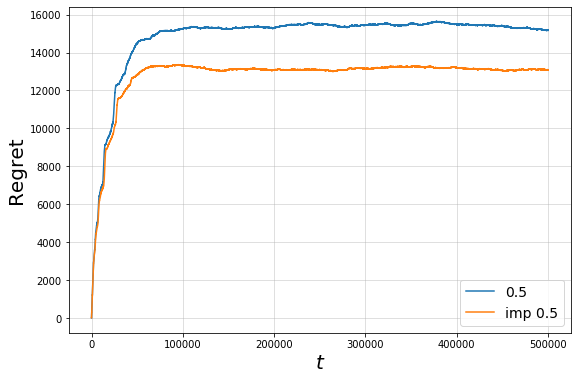

In [ ]:
try:
    regret_reward = np.load('scores_improved/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
    
try:
    regret_reward = np.load('scores_improved/imp_regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label='imp '+str(alpha))   

plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

In [ ]:
T = 20000000

#alpha_list = np.linspace(0, 1, num=6)
alpha_list = np.array([0, 0.1,0.9, 1])
#means = np.random.random((M, K))


means = np.load("/content/movielens_norm_10_40.npy")
M = means.shape[0]
K = means.shape[1]

n_simu = 10

In [ ]:
means

array([[0.94697427, 0.95856988, 0.96557555, 0.97801667, 0.90771832,
        0.97270202, 0.96473004, 0.93537867, 0.9583283 , 0.97306438,
        0.97511777, 0.97572171, 0.96666264, 1.        , 0.9563957 ,
        0.96956154, 0.96666264, 0.9641261 , 0.95518782, 0.95458389,
        0.98164029, 0.9176229 , 0.95422152, 0.93320449, 0.96750815,
        0.96968233, 0.95120184, 0.95712043, 0.93622418, 0.9602609 ,
        0.96074405, 0.94999396, 0.99722189, 0.97705037, 0.98852518,
        0.94902766, 0.95820751, 0.9292185 , 0.96569634, 0.97016548],
       [0.9506347 , 0.96297602, 0.95827457, 0.93653032, 0.95416079,
        0.95921486, 0.98895157, 0.96238834, 0.97038082, 0.97990127,
        0.96732487, 0.92971321, 0.97085096, 0.97872591, 0.94346497,
        0.96897038, 0.9519276 , 0.9570992 , 0.97907851, 0.95874471,
        0.95486601, 0.93993888, 0.97519981, 1.        , 0.96285849,
        0.96039022, 0.97590503, 0.9670898 , 0.99952985, 0.9484015 ,
        0.95463094, 0.93429713, 0.97555242, 0.9

In [ ]:
# try to load for a warm restart
try:
    regret_reward = np.load('/content/scores_movielens/raw_regret_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('/content/scores_movielens/raw_regret_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('/content/scores_movielens/local_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('content/scores_movielens/global_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('content/scores_movielens/mixed_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('/content/scores_movielens/raw_regret_10_40.npy', raw_regret)
    np.save('content/scores_movielens/local_reward_10_40.npy',local_reward)
    np.save('content/scores_movielens/global_reward_10_40.npy',global_reward)
    np.save('content/scores_movielens/mixed_reward_10_40.npy',mixed_reward)
    np.save('content/scores_movielens/regret_reward_10_40.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('scores_movielens/raw_regret_10_40.npy', raw_regret)
    np.save('scores_movielens/local_reward_10_40.npy',local_reward)
    np.save('scores_movielens/global_reward_10_40.npy',global_reward)
    np.save('scores_movielens/mixed_reward_10_40.npy',mixed_reward)
    np.save('scores_movielens/regret_reward_10_40.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward

Simulating P-Fed-UCB, alpha:0.0:  20%|██        | 2/10 [2:19:33<9:21:22, 4210.32s/it] 

C:\Users\shich\Anaconda3\envs\py37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


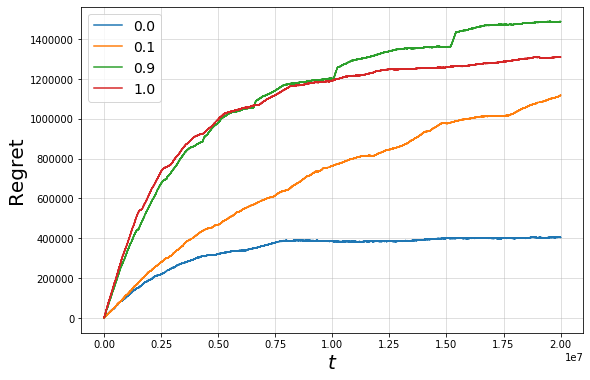

In [ ]:
try:
    regret_reward = np.load('scores_movielens/regret_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

In [ ]:
import numpy as np
np.random.binomial(1, 0.008, 2113)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
a = []
for i in range(100000):
  b = len([index for index, value in enumerate(list(np.random.binomial(1,0.005, 2113))) if value == 1])
  a.append(b)

In [ ]:
np.mean(np.array(a))

10.56414

#Modifications

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm



In [ ]:
#client 
import numpy as np

class client(object):
    def __init__(self,
                 index,
                 thorizon,
                 narms,
                 nclients,
                 palpha,
                 fp):
        self.T = thorizon
        self.id = index
        self.K = narms
        self.M = nclients
        self.alpha = palpha
        self.fp = fp
        
        self.p = 1
        self.local_set = set(np.arange(self.K))
        self.global_set = set(np.arange(self.K))
        self.local_mean = np.zeros(self.K)
        self.global_mean = np.zeros(self.K)
        self.mixed_mean = np.zeros(self.K)
        self.reward = np.zeros(self.K)
        
        self.pull = np.zeros(self.K)
        self.p_length = self.fp(self.p)
        self.Fp = 0
        
        self.fphase = 0
        self.gphase = 0
        
        self.F = -1
        self.l_exploration = False
        self.g_exploration = False
    
    def play(self, Mt):
        if self.fphase < np.ceil((1-self.alpha)*self.p_length)*len(self.global_set): #global exploration
#            print("loc", self.p)
            #play = list(self.global_set)[self.fphase%len(self.global_set)]
            play = list(self.global_set)[int(self.fphase//(np.ceil((1-self.alpha)*self.p_length)))]
            self.fphase += 1
            
        elif self.gphase < np.ceil(Mt*self.alpha*self.p_length)*len(self.local_set): #local exploration
#            print("glob", self.p)
            #play = list(self.local_set)[self.gphase%len(self.local_set)]
            play = list(self.local_set)[int(self.gphase//(np.ceil(Mt*self.alpha*self.p_length)))]
            self.gphase += 1
            
        else: #exploitation phase
            if self.l_exploration is True:
                play = self.F
            else:
                play = np.argmax(self.alpha*self.local_mean+(1-self.alpha)*self.global_mean)
            
        return play
    
    def reward_update(self,play,obs):
        self.reward[play] += obs
        self.pull[play] += 1
        
    def local_mean_update(self, Mt):
        #print('global',self.fphase,np.ceil((1-self.alpha)*self.p_length)*len(self.global_set))
        #print('local',self.gphase,np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set))
        if self.g_exploration is False and self.fphase >= np.ceil((1-self.alpha)*self.p_length)*len(self.global_set) and self.gphase >= np.ceil(Mt*self.alpha*self.p_length)*len(self.local_set):
            self.local_mean = self.reward/self.pull
            #print("local_mean",self.local_mean, "phase", self.p)
            return True, self.local_mean
        else:
            return False, 0
        
    def global_mean_update(self,global_stat):
        self.global_mean = global_stat
        self.mixed_mean = self.alpha*self.local_mean+(1-self.alpha)*self.global_mean
        
    def local_set_update(self, Mt):
        Ep = set()
        self.Fp += self.p_length
        conf_bound = np.sqrt(np.log(self.T)/(Mt*self.Fp))
        for i in list(self.local_set):
            if self.mixed_mean[i]+conf_bound < max(self.mixed_mean-conf_bound):
                Ep.add(i)
        self.local_set = self.local_set-Ep
        
        if len(self.local_set) == 1 and self.l_exploration is False:
            self.l_exploration = True
            self.F = list(self.local_set)[0]
            #print("player", self.id,  " fixate",self.F)
            self.local_set = set()
        #print("player", self.id, " local-set:",self.local_set)    
        return self.local_set
        
        
    def global_set_update(self,global_set):
        self.global_set = global_set
        self.p +=1
        self.p_length = self.fp(self.p)
        #print("p-length",self.p_length)
        self.fphase = 0
        self.gphase = 0
        self.g_exploration = (len(self.global_set)==0)
        
            
            
    
            

In [ ]:
#server

import numpy as np

class server(object):
    def __init__(self,
                 narms,
                 nclients):
        self.M = nclients
        self.K = narms
        #self.Mt = npartclients
        
        self.local_means = np.zeros([self.M,self.K])
        self.global_means = np.zeros(self.K)
        self.global_set = set()
        self.p = 1
        self.c_local_stat = np.zeros(self.M)
        
    def local_mean_update(self,i,local_stat):
        self.local_means[i] = local_stat
        self.c_local_stat[i] = 1
        
    def global_mean_update(self,Mt, part_clients):
        self.global_set = set()
        if sum(self.c_local_stat) >= Mt:
            self.upd = np.array([means[a,:] for a in part_clients])
            self.global_means = np.sum(self.upd, axis=0)/Mt
            self.c_local_stat = np.zeros(self.M)
            return True, self.global_means
        else:
            return False, 0
        
    def local_set_update(self,i,local_set):
        self.global_set = self.global_set|local_set
    
    def global_set_update(self):
        return self.global_set

In [ ]:
#bandits
class PFEDUCB(object):
    def __init__(self,
                 fun_fp,
                 T,
                 means, # M*K
                 alpha,
                 prob,
                 reward='Gaussian'):
        self.M = means.shape[0]
        self.K = means.shape[1]
        self.reward_type = reward
        self.p = prob
        self.alpha = alpha
        self.T = T
        self.C = 1
        self.comm = 0
        #self.part_clients = [index for index, value in enumerate(list(np.random.binomial(1, , self.M))) if value == 1]###################
        #self.Mt = len(self.part_clients)


        
        self.clients = [
            client(index = i, thorizon = self.T, narms=self.K, nclients = self.M, palpha = self.alpha, fp=fun_fp) for i in range(self.M)
        ]
        self.server = server(narms=self.K, nclients = self.M)


    def simulate_single_step_rewards(self):
        if self.reward_type == 'Bernoulli':
            return np.random.binomial(1, self.local_means)
        return np.random.normal(self.local_means, 1)

    def simulate_single_step(self, plays):

        local_rews = self.simulate_single_step_rewards()
        global_rews = np.mean(local_rews,axis=0)
        
        local_rewards = np.array([local_rews[i,plays[i]] for i in range(self.Mt)])
        global_rewards = np.array([global_rews[plays[i]] for i in range(self.Mt)])
        mixed_rewards = self.alpha*local_rewards+(1-self.alpha)*global_rewards
        #rewards = np.array([self.alpha*local_rews[i,plays[i]]+(1-self.alpha)*global_rews[plays[i]] for i in range(self.M)])

        return local_rewards, global_rewards, mixed_rewards

    def simulate(self):
        """
        Return the vector of regret for each time step until horizon
        """

        local_rewards = []
        global_rewards = []
        mixed_rewards = []
        
        play_history = []
        best_case_reward = 0  

        for t in range(self.T):
            
            self.part_clients = [index for index, value in enumerate(list(np.random.binomial(1,self.p, self.M))) if value == 1]
            #print(self.part_clients)
            self.Mt = len(self.part_clients)
            #self.clients = [
            #client(index = i, thorizon = self.T, narms=self.K, nclients = self.Mt, palpha = self.alpha, fp=fun_fp) for i in self.part_clients
        #]
            #self.server = server(narms=self.K, nclients = self.Mt)
            self.local_means = np.array([means[a,:] for a in self.part_clients ])
            #print(self.local_means.shape)
            self.global_means = np.sum(self.local_means, axis=0)/self.Mt
            #print("1",self.global_means)
            plays = np.zeros(self.Mt)

            plays = [(int)(client.play(self.Mt)) for client in [self.clients[part] for part in self.part_clients]]
            #print(plays)
            #np.random.seed(10)
            if self.reward_type == 'Bernoulli':
              local_rews_ = np.random.binomial(1, self.local_means)
            else:
              local_rews_ = np.random.normal(self.local_means, 1)

            global_rews_ = np.mean(local_rews_,axis=0)
            local_rews = np.array([local_rews_[i,plays[i]] for i in range(self.Mt)])
            global_rews = np.array([global_rews_[plays[i]] for i in range(self.Mt)])
            mixed_rews = self.alpha*local_rews+(1-self.alpha)*global_rews
            #local_rews, global_rews, mixed_rews = self.simulate_single_step(plays)
            #obs, rews = self.simulate_single_step(plays)  # observations of all players
            
            local_rewards.append(np.sum(local_rews))
            global_rewards.append(np.sum(global_rews))
            mixed_rewards.append(np.sum(mixed_rews))
            play_history.append(plays)
            
            #print(plays)
            
            for i in range(self.Mt):
                self.clients[self.part_clients[i]].reward_update(plays[i], local_rews[i])  # update strategies of participating players

            for i in range(self.Mt):
                f_local_stat, local_stat = self.clients[self.part_clients[i]].local_mean_update(self.Mt)
                #print(local_stat)
                if f_local_stat is True:
                    self.server.local_mean_update(self.part_clients[i],local_stat)
                f_local_stat = False
                    
            f_global_stat, global_stat = self.server.global_mean_update(self.Mt, self.part_clients)
            
            if f_global_stat is True:
                for i in range(self.Mt):
                    self.clients[self.part_clients[i]].global_mean_update(global_stat)
                    local_set = self.clients[self.part_clients[i]].local_set_update(self.Mt)
                    self.server.local_set_update(i,local_set)
                
                global_set = self.server.global_set_update()
                #print(t," global-set:",global_set)
                for i in range(self.Mt):
                    self.clients[self.part_clients[i]].global_set_update(global_set)
                    local_rewards[-1] -= 2*self.C
                    global_rewards[-1] -= 2*self.C
                    mixed_rewards[-1] -= 2*self.C
                    self.comm += 2*self.C
                    #print(t,"comm")
                f_global_stat = False
            top_mixed_means = np.zeros(self.Mt)
        
            top_arms = np.zeros(self.Mt, dtype=int)
            sub_gap = np.zeros(self.Mt)
            #print("2", self.local_means)
            for i in range(self.Mt):
              top_arms[i] = np.argmax(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)
              top_mixed_means[i] = self.alpha*self.local_means[i][top_arms[i]]+(1-self.alpha)*self.global_means[top_arms[i]]
              sub_gap[i] = np.sort(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)[-2]-top_mixed_means[i]
              #print("player", i, " top_arm:",top_arms[i], " top_mean:", top_mixed_means[i], " gap:", sub_gap[i])
            best_case_reward += np.sum(top_mixed_means) * np.arange(1, self.T + 1)
        
        best_case_reward = best_case_reward/self.T
        cumulated_local_reward = np.cumsum(local_rewards)
        cumulated_global_reward = np.cumsum(global_rewards)
        cumulated_mixed_reward = np.cumsum(mixed_rewards)

        regret = best_case_reward - cumulated_mixed_reward
        #print(cumulated_mixed_reward)
        #print(best_case_reward)
        #print('regret:',regret[-1], "comm: ", self.comm)
        self.regret = (regret, best_case_reward, cumulated_mixed_reward)
        self.top_mixed_means = top_mixed_means
        return regret, cumulated_local_reward, cumulated_global_reward, cumulated_mixed_reward

    def get_clients(self):
        return self.clients

In [ ]:
a = 0
for i in range(10):
  a +=45*np.arange(1,10 +1)

In [ ]:
import pandas as pd

In [ ]:
movies = pd.read_table("/content/movies.dat",engine='python',sep='\t')
movie_genre = pd.read_table("/content/movie_genres.dat",engine='python',sep='\t')
user_data = pd.read_table("/content/user_ratedmovies.dat",engine='python',sep='\t')

In [ ]:

movie_genre.columns = ['id', 'genre']
movie_genre
Movies = movies.merge(movie_genre, how = 'inner', on = ['id'])
Movies

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL,genre
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,0,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...,Adventure
1,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,0,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...,Animation
2,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,0,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...,Children
3,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,0,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...,Comedy
4,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,0,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20804,65126,Choke,1024715,Choke,http://ia.media-imdb.com/images/M/MV5BMTMxMDI4...,2008,choke,5.6,135,73,62,54,4.9,26,8,18,30,3.3,13893,55,http://content6.flixster.com/movie/10/85/09/10...,Comedy
20805,65126,Choke,1024715,Choke,http://ia.media-imdb.com/images/M/MV5BMTMxMDI4...,2008,choke,5.6,135,73,62,54,4.9,26,8,18,30,3.3,13893,55,http://content6.flixster.com/movie/10/85/09/10...,Drama
20806,65130,Revolutionary Road,959337,Revolutionary Road,http://ia.media-imdb.com/images/M/MV5BMTI2MzY2...,2008,revolutionary_road,6.7,194,133,61,68,6.9,36,25,11,69,3.5,46044,70,http://content8.flixster.com/movie/10/88/40/10...,Drama
20807,65130,Revolutionary Road,959337,Revolutionary Road,http://ia.media-imdb.com/images/M/MV5BMTI2MzY2...,2008,revolutionary_road,6.7,194,133,61,68,6.9,36,25,11,69,3.5,46044,70,http://content8.flixster.com/movie/10/88/40/10...,Romance


In [ ]:
Movies_ = Movies[['id', 'genre']]
Movies_.columns = ['movieID', 'genre']
userdat= user_data[['userID', 'movieID', 'rating']]
finaldata =  userdat.merge(Movies_, how = "inner",on = ['movieID'] )
finaldata= finaldata[['userID', 'genre', 'rating']]
final =finaldata.groupby(['userID', 'genre'])['rating'].mean().unstack()
final

genre,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Short,Thriller,War,Western
userID,,,,,,,,,,,,,,,,,,,,
75,3.682927,3.368421,4.000000,2.500000,3.200000,4.153846,NaN,3.588235,3.200000,5.000000,3.500000,NaN,4.500000,3.166667,2.000000,3.343750,NaN,3.920000,2.875000,2.500000
78,3.697917,3.890244,4.352941,3.966667,4.207921,4.129630,4.545455,4.244980,4.000000,4.222222,4.017857,NaN,3.958333,4.134615,4.159722,3.847458,NaN,4.020833,4.185185,3.850000
127,3.611111,2.600000,NaN,3.333333,3.026316,2.625000,1.000000,3.750000,3.833333,NaN,4.222222,1.0,NaN,4.250000,3.500000,3.833333,NaN,4.000000,4.500000,NaN
170,2.833333,2.500000,2.357143,2.000000,2.897959,3.700000,4.000000,3.400000,1.950000,NaN,3.666667,NaN,2.500000,3.833333,2.321429,3.100000,NaN,3.500000,3.000000,2.750000
175,4.043750,4.140351,4.500000,4.444444,4.149351,4.423729,4.500000,4.496753,4.105263,4.444444,3.500000,NaN,4.750000,4.320000,4.290000,3.546875,NaN,4.289157,4.583333,4.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71497,3.670455,3.677778,3.600000,3.377358,3.482143,3.440000,3.000000,3.678571,3.614754,3.250000,3.173913,2.5,3.300000,3.866667,3.641304,3.520000,NaN,3.612069,3.857143,3.600000
71509,3.060284,2.959627,2.944444,2.862903,3.154762,3.708333,3.868852,3.587762,3.267442,4.266667,3.401515,3.5,2.924051,3.743750,3.201087,2.908163,NaN,3.613065,3.423077,3.732143
71525,3.990506,4.086207,4.000000,4.000000,3.775000,4.005814,3.500000,4.090909,3.939394,4.125000,3.870968,NaN,4.100000,3.833333,3.758065,4.073333,NaN,3.962838,4.357143,4.083333


In [ ]:
final = final.fillna(0)

In [ ]:
T = 2000000

alpha_list = np.array([ 0.3])
#means = np.random.random((M, K))
#normalized means
import numpy as np
mean  = np.array(final.values, dtype = 'float64')
means = np.divide(mean , 5.0)
means


means = means[150:160]

n_simu = 10

print(means.shape)

(10, 20)


In [ ]:
means

array([[0.71703704, 0.73516484, 0.8       , 0.76060606, 0.7042654 ,
        0.78026316, 0.5       , 0.73953488, 0.73484848, 0.9       ,
        0.65806452, 1.        , 0.75625   , 0.71290323, 0.71      ,
        0.70555556, 0.        , 0.70215827, 0.77692308, 0.725     ],
       [0.70972222, 0.72578125, 0.7875    , 0.77368421, 0.6836478 ,
        0.72777778, 0.8       , 0.725     , 0.77164179, 0.88      ,
        0.69615385, 0.6       , 0.71777778, 0.7627907 , 0.70536585,
        0.716     , 0.        , 0.7352518 , 0.734375  , 0.6       ],
       [0.        , 0.8       , 0.8       , 0.83333333, 0.81818182,
        0.        , 0.9       , 0.82      , 0.72      , 0.        ,
        0.625     , 0.        , 0.78      , 0.        , 0.84285714,
        0.9       , 0.        , 0.4       , 1.        , 0.        ],
       [0.62374101, 0.62916667, 0.71176471, 0.60416667, 0.65488722,
        0.74      , 0.7875    , 0.7921875 , 0.62432432, 0.7       ,
        0.74102564, 0.        , 0.67058824, 0

In [ ]:
def fp(p):
    return 2**p*np.log(T)

In [ ]:
# try to load for a warm restart
try:
    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('/content/scores/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('/content/scores/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('/content/scores/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('/content/scores/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha, prob = 0.7) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            #del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1



    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('scores/raw_regret.npy', raw_regret)
    np.save('scores/local_reward.npy',local_reward)
    np.save('scores/global_reward.npy',global_reward)
    np.save('scores/mixed_reward.npy',mixed_reward)
    np.save('scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward





Simulating P-Fed-UCB, alpha:0.5:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars




Simulating P-Fed-UCB, alpha:0.5:  10%|█         | 1/10 [22:48<3:25:19, 1368.84s/it]



Simulating P-Fed-UCB, alpha:0.5:  20%|██        | 2/10 [45:40<3:02:36, 1369.54s/it]



Simulating P-Fed-UCB, alpha:0.5:  30%|███       | 3/10 [1:07:20<2:37:22, 1348.88s/it]



Simulating P-Fed-UCB, alpha:0.5:  40%|████      | 4/10 [1:29:47<2:14:49, 1348.18s/it]



Simulating P-Fed-UCB, alph

In [ ]:
regret_reward

{'0.5': [array([3.41201151e-01, 6.62587101e-01, 7.91715508e-01, ...,
         1.79883008e+05, 1.79883275e+05, 1.79884888e+05]),
  array([2.70796665e+00, 2.49832685e+00, 4.18218162e+00, ...,
         2.03114880e+04, 2.03101356e+04, 2.03108897e+04]),
  array([-4.12822775e+00, -4.28676781e+00, -7.54785039e+00, ...,
          1.45138547e+05,  1.45137199e+05,  1.45136598e+05]),
  array([4.31987833e+00, 5.19050216e+00, 6.62929367e+00, ...,
         2.18640776e+05, 2.18634038e+05, 2.18640066e+05]),
  array([5.35508756e+00, 1.07299903e+01, 1.62971506e+01, ...,
         2.97642449e+06, 2.97643058e+06, 2.97643484e+06]),
  array([5.35508756e+00, 1.07299903e+01, 1.62971506e+01, ...,
         2.36007542e+06, 2.36008019e+06, 2.36008410e+06]),
  array([5.35508756e+00, 1.07299903e+01, 1.62971506e+01, ...,
         2.66824995e+06, 2.66825538e+06, 2.66825947e+06])]}

In [ ]:
means

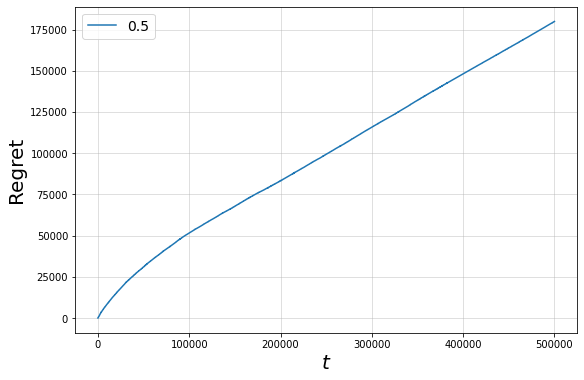

In [ ]:
#try:
#    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
#except FileNotFoundError:
#    regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

In [ ]:
# try to load for a warm restart
try:
    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('/content/scores/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('/content/scores/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('/content/scores/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('/content/scores/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha, prob = 0.8) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            #del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1



    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('scores/raw_regret.npy', raw_regret)
    np.save('scores/local_reward.npy',local_reward)
    np.save('scores/global_reward.npy',global_reward)
    np.save('scores/mixed_reward.npy',mixed_reward)
    np.save('scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward

NameError: ignored

In [ ]:
#try:
#    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
#except FileNotFoundError:
#    regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

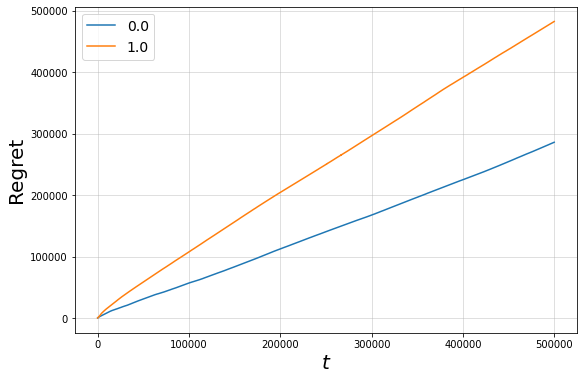

In [ ]:
#try:
#    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
#except FileNotFoundError:
#    regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(5), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha, prob = 0.7) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            #del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1



    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('scores/raw_regret.npy', raw_regret)
    np.save('scores/local_reward.npy',local_reward)
    np.save('scores/global_reward.npy',global_reward)
    np.save('scores/mixed_reward.npy',mixed_reward)
    np.save('scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward

Simulating P-Fed-UCB, alpha:0.5:   0%|          | 0/10 [00:00<?, ?it/s]

alpha: 0.5 Number of tries ran:  0


FileNotFoundError: ignored

In [ ]:
T = 2000000

alpha_list = np.array([ 0.5])
#means = np.random.random((M, K))
#normalized means
import numpy as np
mean  = np.array(final.values, dtype = 'float64')
means = np.divide(mean , 5.0)
means


means = means[150:160]

n_simu = 10

print(means.shape)

(10, 20)
